# Jaws Segmentation Task

Hello, You're tasked with building a neural network using pytorch which segments upper (Maxilla) and lower(Mandible) jaws in a DICOM file

The Dataset is provided as 2D slices from all 3 orthogonal points of view Axial, Coronal, and Sagittal, if you're not familiar with what a DICOM is, you're expected to read online about it

Duration: 1 Week

Deliverables: This notebook (which should contain your solution), and any other files (like saved weights) in a **zip** file, and you mail this **zip** file to us

In [1]:
# ! pip install --user torch torchvision matplotlib numpy progressbar
# %conda install -c conda-forge progressbar

In [2]:
# %conda install -c conda-forge ipywidgets

In [3]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
import json
from tqdm import tqdm

In [4]:
LOCAL_DATASET_PATH = 'dataset'
BATCH_SIZE = 16
AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

In [5]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

## Downloading Dataset

In this part we download the publicly available dataset, you can skip it if you already have it, it should be 5.6 Gb worth of data

In [6]:
download_progress_bar = None
def show_progress(block_num, block_size, total_size):
    global download_progress_bar
    if download_progress_bar is None:
        download_progress_bar = progressbar.ProgressBar(maxval=total_size)
        download_progress_bar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        download_progress_bar.update(downloaded)
    else:
        download_progress_bar.finish()
        download_progress_bar = None

def download_file(url, disk_path):
    print(f'downloading {url}')
    filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
    os.makedirs(disk_path)
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(disk_path)

def download_data(to=LOCAL_DATASET_PATH):
    download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
    download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
    download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
    download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
    download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
    download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

# download_data()

## Explore The Dataset

In this section you should explore/plot the dataset and get familiar with it, we are nice enough to write a dataset loader for you and we did some initial visualization for you

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observations in original Data:</u></b><br>
 
* <i> jaws - labels - float32. 0 - 1 - 2</i><br>
* <i> upper (Maxilla)  - Label: 1 </i><br>
* <i> lower(Mandible)  - Label: 2 </i><br>
* <i> images: float32  range(-1000, 18000) abroximtly ,more or less</i><br>
* <i>axial training dataset: 5043 slice </i><br>
* <i>coronal training dataset: 7277 slice </i><br>
* <i>sagittal training dataset: 7277 slice </i><br>
</div>

In [7]:
LOCAL_DATASET_PATH = 'dataset'
LOCAL_OTUPUT_PATH = 'save_files'
MIN_VAL_LABEL = 0
MAX_VAL_LABEL = 2
BIN_SIZE = 0.1

try:
    with open(f'{LOCAL_OTUPUT_PATH}/labels_dig_{BIN_SIZE}', 'r') as labelsFile:
        plan_dig_dict_sum = dict(json.load(labelsFile))
except Exception:
    planes = ['axial', 'coronal', 'sagittal']
    plan_dig_dict_sum = dict()
    for plane in planes:
        split_dig_dict_sum = dict()
        for split in ['train', 'test']:
            label_dig_dict_sum = dict()
            lbls = glob.glob(
                f'{LOCAL_DATASET_PATH}/{plane}/{split}/**/*.label.npy.gz')
            lbls = sorted(lbls)
            print(f"digtizing for {split} in {plane} labels ...")
            for index, lbl in enumerate(tqdm(lbls)):
                label = gzip.GzipFile(lbl, 'rb')
                label = np.load(label)
                # Convert continuous label in range(0, 2) into digital value
                #  with bin size = BIN_SIZE
                intervals = np.arange(MAX_VAL_LABEL * 10 + 1, step=BIN_SIZE*10)/10
                index = np.digitize(label.reshape(-1), intervals) - 1
                dig_label=intervals[index]
                values, counts = np.unique(dig_label, return_counts=True)
                values = [str(value) for value in values ]
                label_dig_dict = dict(zip(values, counts))
                for value, count in label_dig_dict.items():
                    if value in label_dig_dict_sum:
                        label_dig_dict_sum[value] += count
                    else:
                        label_dig_dict_sum[value] = count
            split_dig_dict_sum[split] = label_dig_dict_sum
        plan_dig_dict_sum[plane] = split_dig_dict_sum

    if os.path.isdir(LOCAL_OTUPUT_PATH) == False:
        os.mkdir(LOCAL_OTUPUT_PATH)
    with open(f'{LOCAL_OTUPUT_PATH}/labels_dig_{BIN_SIZE}', 'w') as labelsFile:
        labelsFile.write(json.loads(json.dumps(
            str(plan_dig_dict_sum))).replace("'", '"'))
    print('Done')


In [8]:
# for j, split in enumerate(['train', 'test']):
#     for i, plane in enumerate(['axial', 'coronal', 'sagittal']):
#         print(plan_dig_dict_sum[plane][split])

In [9]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.figure(figsize=(14, 6))
subplot_titles = list()
for j, split in enumerate(['train', 'test']):
    for i, plane in enumerate(['axial', 'coronal', 'sagittal']):
        subplot_titles.append(f'{plane}_{split}')
fig = make_subplots(rows=2, cols=3, subplot_titles=subplot_titles,  x_title='Values', y_title='Count')
for j, split in enumerate(['train', 'test']):
    for i, plane in enumerate(['axial', 'coronal', 'sagittal']):
        values = list(plan_dig_dict_sum[plane][split].keys())
        counts = list(plan_dig_dict_sum[plane][split].values())
        data = go.Bar(x=values, y=counts)
        # data = go.Scatter(x=[1, 2, 3], y=[4, 5, 6])
        fig.add_trace(data, row=j + 1, col=i + 1)

fig.update_layout(height=400, width=600, title_text="digital Labels")
fig.show()


<Figure size 1008x432 with 0 Axes>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Processing Data:</u></b><br>
 
* <i> jaws - labels - int32. 0, 1, 2</i><br>
* <i> labels - Resized with nearest(to avoid interpolation) - tensor - int</i><br>
* <i> Background - Label: 0</i><br>
* <i> upper (Maxilla)  - Label: 1 </i><br>
* <i> lower(Mandible)  - Label: 2 </i><br>
* <i> images: float32 range(0, 1) Normalized - resized - tensor</i><br>


## Preprocessing The Dataset

In [10]:
def transformations(is_label: bool):
    global IMAGE_HEIGHT, IMAGE_WIDTH
    interpolation = [transforms.InterpolationMode.BICUBIC,
                     transforms.InterpolationMode.NEAREST]
    dataset_transforms = transforms.Compose([transforms.ToTensor(),
                                             transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=interpolation[is_label])])
    return dataset_transforms

In [11]:
class JawsDataset(torch.utils.data.Dataset):
    def __init__(self, dicom_file_list, normalize=True):
        self.dicom_file_list = dicom_file_list
        self.normalize = normalize
        self.images_transforms = transformations(False)
        self.label_transforms = transformations(True)
    def __len__(self):
        return len(self.dicom_file_list)

    def __getitem__(self, idx):
        dicom_path = self.dicom_file_list[idx]
        label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
        dicom_file = gzip.GzipFile(dicom_path, 'rb')
        dicom = np.load(dicom_file)
        dicom = dicom.astype('float32')
        dicom = self.images_transforms(dicom)
        if self.normalize:
            spread = dicom.max() - dicom.min()

            if spread != 0:
                dicom = (dicom - dicom.min()) / spread
            else:
                dicom = torch.zeros(dicom.shape)

        label_file = gzip.GzipFile(label_path, 'rb')
        label = np.load(label_file)
        label = label.astype('float32')
        label = self.label_transforms(label).long()
        return dicom, label


def axial_dataset_train(validation_ratio=0.1):
    files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:]),
            JawsDataset(files[:validation_files_count]))


def coronal_dataset_train(validation_ratio=0.1):
    files = glob.glob('dataset/coronal/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:]),
            JawsDataset(files[:validation_files_count]))


def sagittal_dataset_train(validation_ratio=0.1):
    files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
    assert len(files) > 0
    validation_files_count = ceil(len(files) * validation_ratio)

    return (JawsDataset(files[validation_files_count:]),
            JawsDataset(files[:validation_files_count]))


def axial_dataset_test():
    files = glob.glob('dataset/axial/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files)


def coronal_dataset_test():
    files = glob.glob('dataset/coronal/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files)


def sagittal_dataset_test():
    files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
    assert len(files) > 0
    return JawsDataset(files)


In [12]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train()
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train()
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train()
print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')

axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 5043 slice
coronal training dataset: 7277 slice
sagittal training dataset: 7277 slice


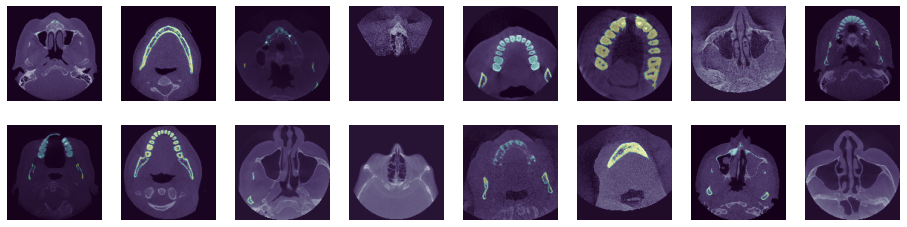

In [13]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

In [14]:
label = labels[1]

values, counts = np.unique(label, return_counts=True)
label_dig_dict = dict(zip(values, counts))
print(label_dig_dict)

{0: 15775, 2: 609}


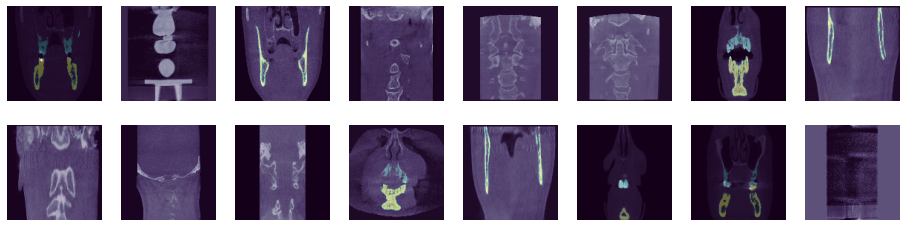

In [15]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

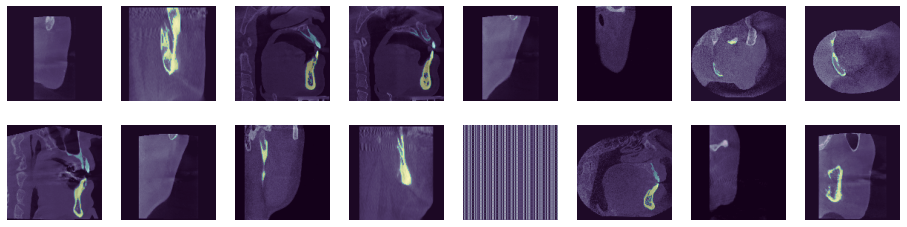

In [16]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

## Augmentation
- Tranformation for Trianing or both training & validation

## Training

Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Modeling:</u></b><br>
 
* <i> Choose model: UNET</i><br>
* <i> Prefere to make a single model for each view to get better results</i><br>


### <span style="color:#e76f51;">References</span>

- U-Net: Convolutional Networks for Biomedical Image Segmentation: https://arxiv.org/pdf/1505.04597.pdf

- Pytorch-UNet: https://github.com/milesial/Pytorch-UNet

## Testing

Now you should run your trained model on the test dataset available below and report your results

In [17]:
axial_test_dataset = axial_dataset_test()
coronal_test_dataset = coronal_dataset_test()
sagittal_test_dataset = sagittal_dataset_test()
print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial testing dataset: 1450 slice
coronal testing dataset: 2348 slice
sagittal testing dataset: 2448 slice
